In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.feature import peak_local_max

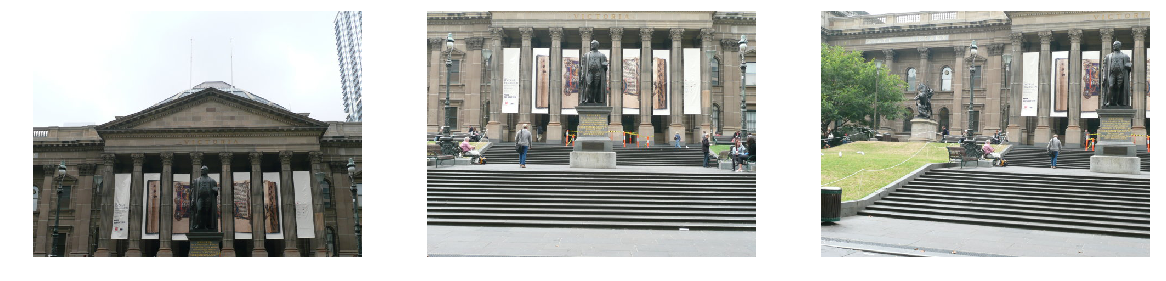

In [2]:
"""
Read a set of images for Panorama stitching
"""
%matplotlib inline
path = '../Data/Train/Set1/'
img1 = cv2.imread(path+'1.jpg')
img2 = cv2.imread(path+'2.jpg')
img3 = cv2.imread(path+'3.jpg')
img1=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3=cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis('off')
plt.imshow(img1)
plt.subplot(132)
plt.axis('off')
plt.imshow(img2)
plt.subplot(133)
plt.axis('off')
plt.imshow(img3)

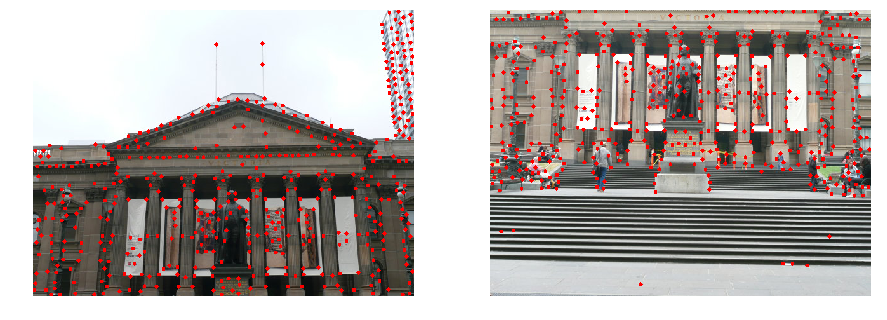

In [3]:
"""
Corner Detection
Save Corner detection output as corners.png
"""
def corner_detect_with_ANMS(img,n=500):   
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray_img,n,0.02,10)
    corners = np.int0(corners)
    img_temp = img.copy()
    x_best = []
    y_best = []
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img_temp,(x,y),3,255,-1)
        x_best.append(y)
        y_best.append(x)
    return x_best,y_best,img_temp,corners

x1,y1,img1_corner,corners1 = corner_detect_with_ANMS(img1)
x2,y2,img2_corner,corners2 = corner_detect_with_ANMS(img2)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.axis('off')
plt.imshow(img1_corner)
plt.subplot(122)
plt.axis('off')
plt.imshow(img2_corner)



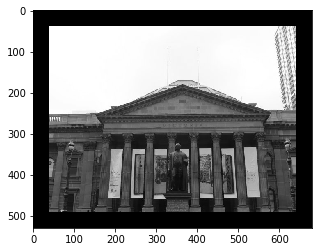

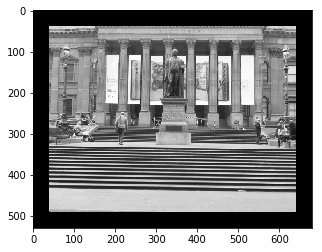

In [4]:
"""
Feature Descriptors
Save Feature Descriptor output as FD.png
"""
def feature_des(img,x_best,y_best):
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    top = 40
    bottom = top
    left = 40
    right = left 
    dst = cv2.copyMakeBorder(gray_img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, [0])
    plt.figure()
    plt.imshow(dst,cmap='gray')
    features = []
    for i in range(len(x_best)):
        patch = dst[x_best[i]+20:x_best[i]+60,y_best[i]+20:y_best[i]+60]
        patch = cv2.GaussianBlur(patch,(5,5),cv2.BORDER_DEFAULT)
        patch = cv2.resize(patch, (8,8), interpolation = cv2.INTER_AREA)
        feature = np.reshape(patch, (64, ))
        mean = np.mean(feature)
        std = np.std(feature)
        feature = (feature - mean)/std
        features.append(feature)
    return features

features1 = feature_des(img1,x1,y1)
features2 = feature_des(img2,x2,y2)

172
485
172


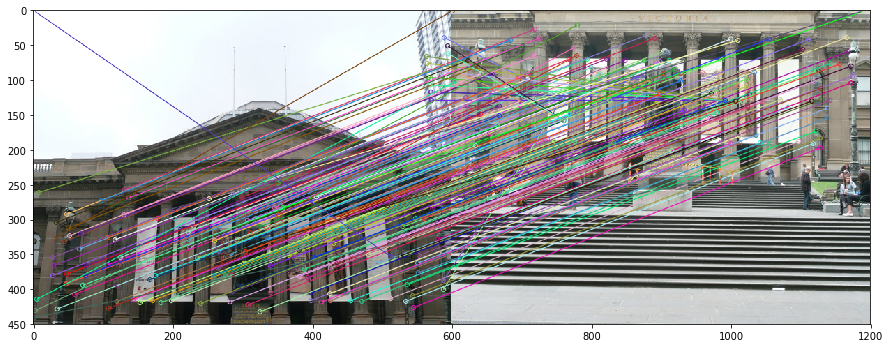

In [5]:
"""
Feature Matching
Save Feature Matching output as matching.png
"""
features1 = np.array(features1,dtype='float32')
features2 = np.array(features2,dtype='float32')


bf = cv2.BFMatcher()

rawMatches = bf.knnMatch(features1,features2,2)


# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])
# pts1 = np.float32([corners1[i][0] for i in corners1])
# pts2 = np.float32([corners2[i][0] for i in corners2])
# print(pts1.shape)



matches = []
good = []
c=0
for m in rawMatches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches.append((m[0].trainIdx, m[0].queryIdx))
        good.append([m[0]])
        c = c+1
print(c)
print(corners1.shape[0])
# pts1 = np.float32([corners1[i][0] for (_, i) in matches])
# pts2 = np.float32([corners2[i][0] for (i, _) in matches])
# pts1 = np.reshape(pts1,(c,2))
# pts2 = np.reshape(pts2,(c,2))

pts1 = np.float32(corners1)
pts2 = np.float32(corners2)
pts1 = np.reshape(pts1,(corners1.shape[0],2))
pts2 = np.reshape(pts2,(corners2.shape[0],2))
# print(pts1)
# print(corners1)
kp1=[]
kp2=[]
for i in range(len(pts1)):
    kp1.append(cv2.KeyPoint(pts1[i][0], pts1[i][1], 5))
    kp2.append(cv2.KeyPoint(pts2[i][0], pts2[i][1], 5))


img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
  

plt.figure(figsize=(15,15))
plt.imshow(img)

# points1 = np.float32([point.pt for point in kp1])
# points2 = np.float32([point.pt for point in kp2])

pts1f = np.float32([pts1[i] for (_, i) in matches])
pts2f = np.float32([pts2[i] for (i, _) in matches])
print(len(pts1f))

In [19]:
"""
Refine: RANSAC, Estimate Homography
"""
def ransac(pts1, pts2, N=10, t=0.60, thresh=2.0):

    totalPoints = len(pts1)

    bestH = np.zeros((3,3))
    maxInliers = 0
    
    for j in range(N):
        pts1n = []
        pts2n = []
        randFour = [np.random.randint(0,totalPoints) for i in range(4)]
        p1 = pts1[randFour]
        p2 = pts2[randFour]
#         H = homography(p1,p2)
        H = cv2.getPerspectiveTransform( np.float32(p1), np.float32(p2) )
        inLiers = 0
        for ind in range(totalPoints):
            source = pts1[ind]
            target = np.array([pts2[ind][0],pts2[ind][1]])
            pred = np.dot(H, np.array([source[0],source[1],1]))
            predx = pred[0]/pred[2]
            predy = pred[1]/pred[2]
            pred = np.array([predx,predy])
            pred = np.float32([point for point in pred])
#             print(np.linalg.norm(target-pred))
            if np.linalg.norm(target-pred) < thresh:
                inLiers += 1
                pts1n.append(pts1[ind])
                pts2n.append(pts2[ind])

        if maxInliers < inLiers:
            maxInliers = inLiers
            bestH = H
            if inLiers > t*totalPoints:
                break
    return bestH,pts1n,pts2n

def homography(p1,p2):
    A = []
    for i in range(0, len(p1)):
        x, y = p1[i][0], p1[i][1]
        u, v = p2[i][0], p2[i][1]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1,:] / Vh[-1,-1]
    H = L.reshape(3, 3)
    return H

172
[[ 1.09523966e+00  3.09351182e-02 -2.48870970e+01]
 [ 2.26362318e-02  1.08992575e+00 -2.54657348e+02]
 [ 2.73298283e-05  2.14490874e-04  1.00000000e+00]]


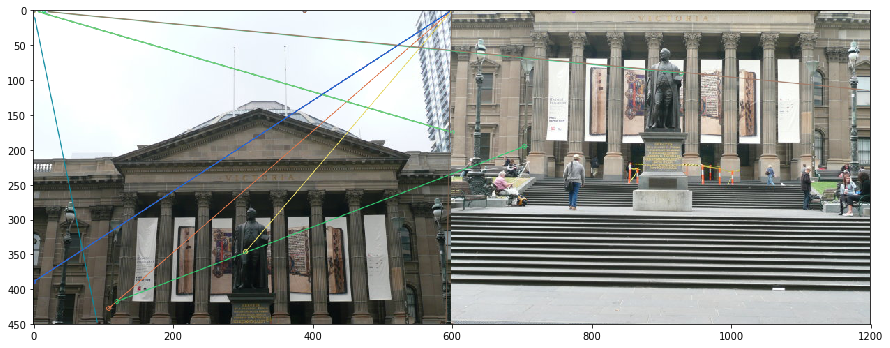

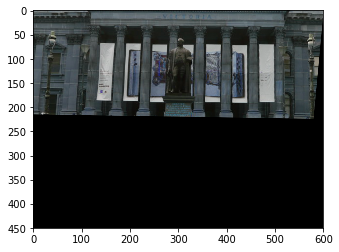

In [23]:
H,pts1n,pts2n = ransac(pts1f,pts2f)
print(len(pts1f))
# H = np.float64([pt for pt in H])
print(H)
result = cv2.warpPerspective(img1, H,(img1.shape[1], img1.shape[0]))
# result[0:img2.shape[0], 0:img2.shape[1]] = img2
kp1n=[]
kp2n=[]
for i in range(len(pts1n)):
    kp1n.append(cv2.KeyPoint(pts1n[i][0], pts1n[i][1], 5))
    kp2n.append(cv2.KeyPoint(pts2n[i][0], pts2n[i][1], 5))


img = cv2.drawMatchesKnn(img1,kp1n,img2,kp2n,good,None,flags=2)
plt.figure(figsize=(15,15))
plt.imshow(img)
# print(H)
plt.figure()
result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(15,15))
plt.imshow(result)

In [8]:
def create_mask(img_mask, img_target, img_src, offset=(0, 0)):
    '''
    Takes the np.array from the grayscale image
    '''

    # crop img_mask and img_src to fit to the img_target
    hm, wm = img_mask.shape
    ht, wt, nl = img_target.shape

    hd0 = max(0, -offset[0])
    wd0 = max(0, -offset[1])

    hd1 = hm - max(hm + offset[0] - ht, 0)
    wd1 = wm - max(wm + offset[1] - wt, 0)

    mask = np.zeros((hm, wm))
    mask[img_mask > 0] = 1
    mask[img_mask == 0] = 0

    mask = mask[hd0:hd1, wd0:wd1]
    src = img_src[hd0:hd1, wd0:wd1]

    # fix offset
    offset_adj = (max(offset[0], 0), max(offset[1], 0))

    # remove edge from the mask so that we don't have to check the
    # edge condition
    mask[:, -1] = 0
    mask[:, 0] = 0
    mask[-1, :] = 0
    mask[0, :] = 0

    return mask, src, offset_adj


def get_gradient_sum(img, i, j, h, w):
    """
    Return the sum of the gradient of the source imgae.
    * 3D array for RGB
    """

    v_sum = np.array([0.0, 0.0, 0.0])
    v_sum = img[i, j] * 4 \
        - img[i + 1, j] - img[i - 1, j] - img[i, j + 1] - img[i, j - 1]

    return v_sum


def get_mixed_gradient_sum(img_src, img_target, i, j, h, w, ofs,
                           c=1.0):
    """
    Return the sum of the gradient of the source imgae.
    * 3D array for RGB
    c(>=0): larger, the more important the target image gradient is
    """

    v_sum = np.array([0.0, 0.0, 0.0])
    nb = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

    for kk in range(4):

        fp = img_src[i, j] - img_src[i + nb[kk, 0], j + nb[kk, 1]]
        gp = img_target[i + ofs[0], j + ofs[1]] \
            - img_target[i + nb[kk, 0] + ofs[0], j + nb[kk, 1] + ofs[1]]

        # if np.linalg.norm(fp) > np.linalg.norm(gp):
        #     v_sum += fp
        # else:
        #     v_sum += gp

        v_sum += np.array([fp[0] if abs(fp[0] * c) > abs(gp[0]) else gp[0],
                           fp[1] if abs(fp[1] * c) > abs(gp[1]) else gp[1],
                           fp[2] if abs(fp[2] * c) > abs(gp[2]) else gp[2]])

    return v_sum


def poisson_blend(img_mask, img_src, img_target, method='mix', c=1.0,
                  offset_adj=(0,0)):

    hm, wm = img_mask.shape
    region_size = hm * wm

    F = np.zeros((region_size, 3))
    A = scipy.sparse.identity(region_size, format='lil')

    get_k = lambda i, j: i + j * hm

    # plane insertion
    if method in ['target', 'src']:
        for i in range(hm):
            for j in range(wm):
                k = get_k(i, j)

                # ignore the edge case (# of neighboor is always 4)
                if img_mask[i, j] == 1:

                    if method == 'target':
                        F[k] = img_target[i + offset_adj[0], j + offset_adj[1]]
                    elif method == 'src':
                        F[k] = img_src[i, j]
                else:
                    F[k] = img_target[i + offset_adj[0], j + offset_adj[1]]

    # poisson blending
    else:
        if method == 'mix':
            grad_func = lambda ii, jj: get_mixed_gradient_sum(
                img_src, img_target, ii, jj, hm, wm, offset_adj, c=c)
        else:
            grad_func = lambda ii, jj: get_gradient_sum(
                img_src, ii, jj, hm, wm)

        for i in range(hm):
            for j in range(wm):
                k = get_k(i, j)

                # ignore the edge case (# of neighboor is always 4)
                if img_mask[i, j] == 1:
                    f_star = np.array([0.0, 0.0, 0.0])

                    if img_mask[i - 1, j] == 1:
                        A[k, k - 1] = -1
                    else:
                        f_star += img_target[i - 1 +
                                             offset_adj[0], j + offset_adj[1]]

                    if img_mask[i + 1, j] == 1:
                        A[k, k + 1] = -1
                    else:
                        f_star += img_target[i + 1 +
                                             offset_adj[0], j + offset_adj[1]]

                    if img_mask[i, j - 1] == 1:
                        A[k, k - hm] = -1
                    else:
                        f_star += img_target[i +
                                             offset_adj[0], j - 1 + offset_adj[1]]

                    if img_mask[i, j + 1] == 1:
                        A[k, k + hm] = -1
                    else:
                        f_star += img_target[i +
                                             offset_adj[0], j + 1 + offset_adj[1]]

                    A[k, k] = 4
                    F[k] = grad_func(i, j) + f_star

                else:
                    F[k] = img_target[i + offset_adj[0], j + offset_adj[1]]

    A = A.tocsr()

    img_pro = np.empty_like(img_target.astype(np.uint8))
    img_pro[:] = img_target.astype(np.uint8)

    for l in range(3):
        # x = pyamg.solve(A, F[:, l], verb=True, tol=1e-15, maxiter=100)
        x = scipy.sparse.linalg.spsolve(A, F[:, l])
        x[x > 255] = 255
        x[x < 0] = 0
        x = np.array(x, img_pro.dtype)

        img_pro[offset_adj[0]:offset_adj[0] + hm,
                offset_adj[1]:offset_adj[1] + wm, l]\
            = x.reshape(hm, wm, order='F')

    return img_pro

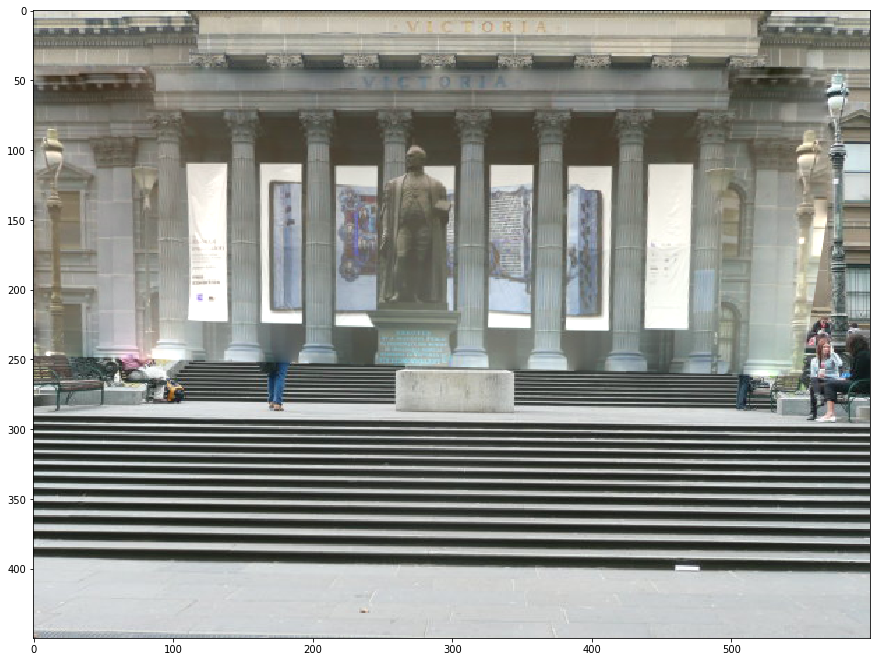

In [9]:
from skimage import data, io
import scipy.sparse
# from scipy.sparse import coo_matrix


offset = (40, -30)    
img_mask = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
img_src = result.astype(np.float64)
img_target = img2

img_mask, img_src, offset_adj \
    = create_mask(img_mask.astype(np.float64),img_target, img_src, offset=offset)

img_pro = poisson_blend(img_mask, img_src, img_target,method='normal', offset_adj=offset_adj)
plt.figure(figsize=(15,15))
plt.imshow(img_pro)